In [1]:
import os
import math

from kneed import KneeLocator

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder, StandardScaler


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
WORKDIR = os.path.abspath(os.getcwd())

YEARS_AVAILABLE = [2014, 2018, 2021]

## Get the data

__Load into Pandas DataFrame__

In [3]:
file = ''.join([WORKDIR, "/data/output/hotspot_spi.csv"]) 
dataset = pd.read_csv(file)

dataset

,ano,estado,municipio,diasemchuva,precipitacao,riscofogo,frp,fococalor,riscofogocat,IPS Amazônia,...,Gravidez na infância e adolescência,Trabalho Infantil,Vulnerabilidade familiar,Violência contra indígenas,Violência contra indígenas Taxa,Violência contra mulheres,Violência infantil,Violência infantil Taxa,Empregos ensino superior,Mulheres com empregos ensino superior
0,2014,ACRE,ACRELANDIA,0.9,0.38,0.23,0.00,441,BAIXO,54.64,...,26.77,288.91,12.27,0.00,1.0,29.60,22.32,2.0,13.81,7.35
1,2014,ACRE,ASSIS BRASIL,1.7,0.46,0.15,0.00,327,MUITO_BAIXO,53.48,...,36.22,201.25,17.35,1.88,2.0,58.91,80.48,3.0,8.17,4.54
2,2014,ACRE,BRASILEIA,1.4,0.36,0.19,0.00,1120,BAIXO,50.05,...,31.08,144.83,20.11,40.00,5.0,300.00,683.19,5.0,9.97,6.59
3,2014,ACRE,BUJARI,0.8,0.36,0.12,0.00,339,MUITO_BAIXO,54.02,...,34.30,824.47,16.12,0.00,1.0,45.11,32.66,2.0,12.97,9.16
4,2014,ACRE,CAPIXABA,0.8,0.10,0.08,0.00,455,MUITO_BAIXO,53.15,...,32.05,172.42,26.07,0.00,1.0,0.00,0.00,1.0,11.60,7.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,2021,TOCANTINS,TOCANTINOPOLIS,23.2,0.32,0.85,9.03,799,ALTO,53.76,...,25.06,19.09,58.55,16.50,4.0,632.00,433.17,5.0,15.30,11.06
2312,2021,TOCANTINS,TUPIRAMA,39.5,0.94,0.81,7.53,180,ALTO,53.14,...,30.77,9.64,53.85,0.00,1.0,148.61,141.85,4.0,20.10,14.28
2313,2021,TOCANTINS,TUPIRATINS,43.5,0.41,0.89,9.99,690,ALTO,60.37,...,32.14,3.05,28.57,0.00,1.0,159.21,0.00,1.0,19.09,15.72
2314,2021,TOCANTINS,WANDERLANDIA,17.7,0.42,0.80,4.85,622,ALTO,54.31,...,27.59,11.80,81.03,0.00,1.0,0.00,24.26,2.0,15.15,12.15


In [4]:
le = LabelEncoder()

dataset["estado"] = le.fit_transform(dataset["estado"])
dataset["municipio"] = le.fit_transform(dataset["municipio"])

## Functions

#### The Elbow Method

In [5]:
def peform_elbow_method(kmeans_kwargs, n_inter, features):
    sse = []
    min_cluster = 1
    
    for k in range(min_cluster, n_inter):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(features)
        sse.append(kmeans.inertia_)
    
    show_elbow_method(sse, n_inter, min_cluster)

        
def show_elbow_method(sse, n_inter, min_cluster):
    kl = KneeLocator(
        range(1, n_inter), 
        sse, 
        curve="convex", 
        direction="decreasing")
    
    plt.plot(range(1, n_inter), sse)
    
    plt.xticks(range(1, n_inter))
    plt.xlabel("Number of Clusters")
    plt.axvline(kl.elbow, c='tab:gray', ls='--')
    
    plt.ylabel("SSE")
    plt.show()

#### The Silhouette Coefficients

In [6]:
def peform_silhouette_coefficients(kmeans_kwargs, n_inter, features):
    #The silhouette score() function needs a minimum of two clusters, or it will raise an exception.
    min_cluster = 2
    sicoefs = []
    
    for k in range(min_cluster, n_inter):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(features)
        score = silhouette_score(features, kmeans.labels_)
        sicoefs.append(score)
        
    show_silhouette_coefficients(sicoefs, n_inter, min_cluster)

def show_silhouette_coefficients(sicoefs, n_inter, min_cluster):
    plt.plot(range(min_cluster, n_inter), sicoefs)
    plt.xticks(range(min_cluster, n_inter))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()

def xyz(features, true_labels, n_cluster=10, n_cluster_val=11):
    print("===========================================================")
    print("Features:\n", features[:5])
    print("True Labels:\n", true_labels[:5])
    print("===========================================================")
    
    
    # Standarization
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    print("Scaled Features:\n", scaled_features[:5])
    print("===========================================================")
    
    
    # Create KMeans Model
    kmeans = KMeans(n_clusters=n_cluster)
    _ = kmeans.fit(scaled_features)
    
    
    # show data points clusters
    y_pred = kmeans.fit_predict(scaled_features)
    plt.figure(figsize=(10, 10))
    plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=y_pred)
    plt.show()
    
    
    # Statistics from the initialization
    print("===========================================================")
    # The lowest SSE value
    print("Lowest SSE Value:", kmeans.inertia_)

    # The number of iterations required to converge
    print("Iterations Required to Converge:", kmeans.n_iter_)

    # Final locations of the centroid
    print("Final locations of the centroid:\n", kmeans.cluster_centers_)
    print("===========================================================")
    
        
    # Choosing the Appropriate Number of Clusters
    kmeans_kwargs = kmeans.get_params()
    del kmeans_kwargs['n_clusters']
    
    peform_elbow_method(kmeans_kwargs, n_cluster_val, scaled_features)
    peform_silhouette_coefficients(kmeans_kwargs, n_cluster_val, scaled_features)

## Model Params

In [7]:
YEAR = 2021
N_CLUSTER = 4

## 1º Study Case - Only the dimensions

Features:
 [[65.4  57.17 38.54]
 [64.29 57.94 33.64]
 [68.39 62.73 23.25]
 [65.47 54.54 43.7 ]
 [63.87 53.6  31.55]]
True Labels:
 ['MODERADO' 'BAIXO' 'BAIXO' 'BAIXO' 'BAIXO']
Scaled Features:
 [[-0.12723321  0.2618465  -0.53381619]
 [-0.30567038  0.40539191 -1.33506365]
 [ 0.35342187  1.29835622 -3.03403531]
 [-0.11598041 -0.22844497  0.30994644]
 [-0.37318714 -0.40368223 -1.67682022]]


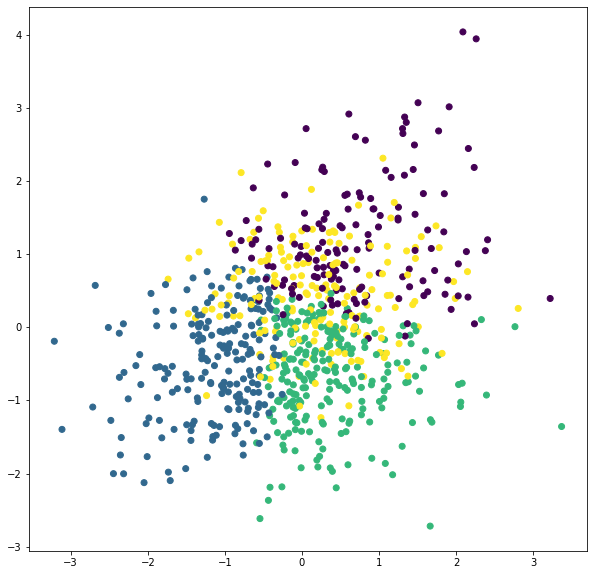

Lowest SSE Value: 1067.520844348792
Iterations Required to Converge: 16
Final locations of the centroid:
 [[ 0.70006153  1.2043868   0.92398543]
 [-1.14073023 -0.47487405  0.00809031]
 [ 0.39089259 -0.66388396  0.38558825]
 [ 0.21715798  0.4151817  -1.29201864]]


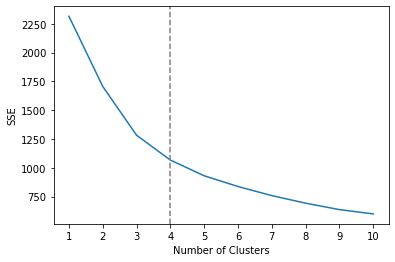

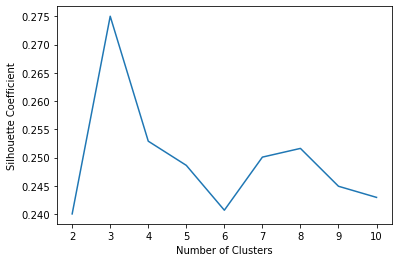

In [8]:
dsyear = dataset[dataset["ano"] == YEAR]
true_labels = dsyear["riscofogocat"].values
features = dsyear[[
    "Necessidades Humanas Básicas",
    "Fundamentos para o Bem-Estar",
    "Oportunidades"
]].values
xyz(features, true_labels, n_cluster=N_CLUSTER)

## 2º Study Case - "Necessidades Humanas Básicas" Components

Features:
 [[94.41 39.1  80.43 47.68]
 [86.82 54.09 71.64 44.6 ]
 [90.89 57.73 76.78 48.15]
 [88.33 47.88 75.7  49.95]
 [91.81 30.22 84.49 48.94]]
True Labels:
 ['MODERADO' 'BAIXO' 'BAIXO' 'BAIXO' 'BAIXO']
Scaled Features:
 [[ 1.06867574 -0.02663687 -0.00655035 -0.57121892]
 [-0.29631263  0.90756507 -0.67047717 -0.77642305]
 [ 0.43563766  1.13441597 -0.28224238 -0.5399053 ]
 [-0.02475368  0.52054746 -0.363817   -0.41998081]
 [ 0.60109079 -0.58005336  0.30010982 -0.48727178]]


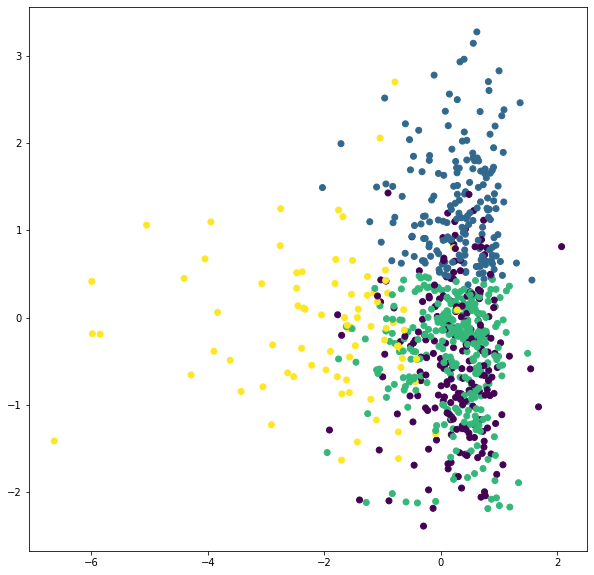

Lowest SSE Value: 1639.794902853805
Iterations Required to Converge: 13
Final locations of the centroid:
 [[ 0.23081078 -0.47844193 -1.14295758  0.6376399 ]
 [ 0.30256578  1.28665398  0.39274569 -0.42179819]
 [ 0.20036032 -0.41411574  0.45818799 -0.50512238]
 [-2.01418775 -0.08233398  0.32850428  1.20357306]]


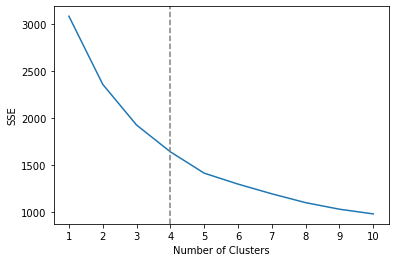

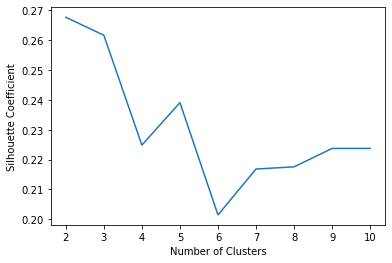

In [9]:
dsyear = dataset[dataset["ano"] == YEAR]
true_labels = dsyear["riscofogocat"].values
features = dsyear[[
    "Nutrição e cuidados médicos básicos",
    "Água e saneamento",
    "Moradia",
    "Segurança pessoal"
]].values

xyz(features, true_labels, n_cluster=N_CLUSTER)

## 3º Study Case - "Oportunidades" Components

Features:
 [[27.24 56.99 61.69  8.25]
 [19.38 63.72 35.24 16.22]
 [22.43 60.59  0.    9.97]
 [28.45 57.54 75.26 13.55]
 [24.41 58.61 34.87  8.33]]
True Labels:
 ['MODERADO' 'BAIXO' 'BAIXO' 'BAIXO' 'BAIXO']
Scaled Features:
 [[ 0.90164177  0.09827636 -0.6877511  -0.54797504]
 [-0.2466059   0.85788409 -1.86382415  0.39661555]
 [ 0.19896094  0.50460442 -3.43073585 -0.34412362]
 [ 1.07840763  0.16035426 -0.08437449  0.08017177]
 [ 0.48821417  0.28112398 -1.88027584 -0.53849358]]


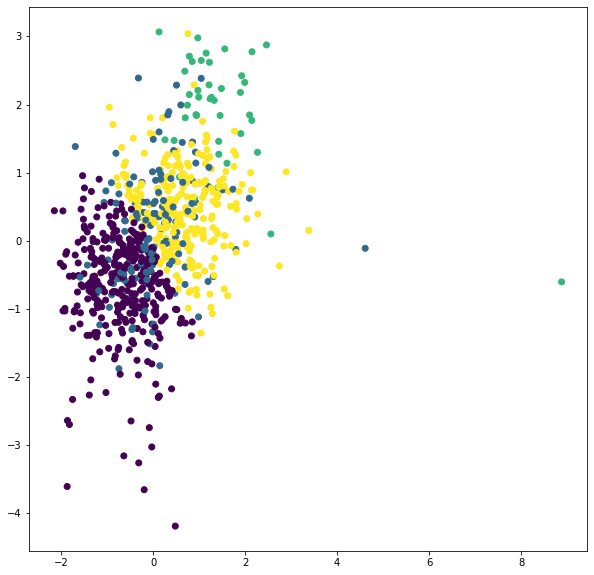

Lowest SSE Value: 1530.0872380866383
Iterations Required to Converge: 12
Final locations of the centroid:
 [[-0.70387283 -0.66964998  0.45054347 -0.25862773]
 [ 0.03702025  0.16260327 -1.59247512 -0.08820318]
 [ 1.45221769  1.89114517 -1.21875724  2.59321055]
 [ 0.653102    0.47289694  0.44323032 -0.03987356]]


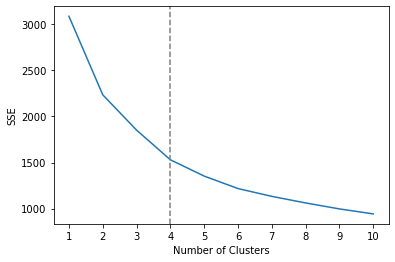

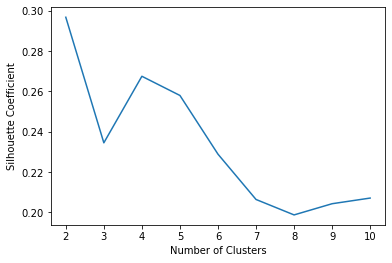

In [10]:
dsyear = dataset[dataset["ano"] == YEAR]
true_labels = dsyear["riscofogocat"].values
features = dsyear[[
    "Direitos individuais",
    "Liberdade individual e de escolha",
    "Tolerância e inclusão",
    "Acesso à educação superior"
]].values

xyz(features, true_labels, n_cluster=N_CLUSTER)

## 4º Study Case - "Fundamentos para o Bem-Estar" Components

#### Predicted Labels

In [11]:
# kmeans.labels_[:5]

NameError: name 'kmeans' is not defined